# [NSF's OIR Lab](https://nationalastro.org/) Astro Data Archive: How to make an exposure map for a survey


Knut Olsen, [Community Science and Data Center](https://nationalastro.org/programs/csdc/) (slightly modified by Steve Pothier)

### Table Of Contents:
* [Goals & notebook summary](#goals)
* [Imports and setup](#init)
* [Details](#details)
* [Where do we look for the fields that we need?](#hdu_search)
* [Doing the search](#search)
* [Combining results](#combine)
* [Computing $t_{\rm eff}$](#teff)
* [Making the depth map](#depth)
* [Resources and references](#doc)



<a class="anchor" id="goals"></a>
# Goals
Use the Advanced Search API to make an exposure map for a survey.  We'll use the Dark Energy Survey DES) as an example.

# Notebook Summary
We show you how to use the API to search the Archive for relevant information from individual r-band HDUs as well as the primary HDUs.  We'll combine information on FWHM, transparency, and sky background to compute maps of effective exposure time, following the procedure adopted by DES.

<a class="anchor" id="init"></a>

# Imports and setup

In [1]:
# UTILS are settings for HOST etc. that you won't need to use the API
# but are used here to make this notebook more portable.
%run utils.ipynb
tic() # start tracking time of Notebook load

Using server on https://astroarchive.noao.edu
About NSF's OIR Lab Astro Data Archive: https://astroarchive.noao.edu/about/


In [2]:
import sys
import copy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import requests
import json
import healpy as hp
from pprint import pprint as pp  # pretty print

print(f'Using Python version: {sys.version}\n')
with open ("requirements.txt", "r") as f:
    data=f.readlines()
print(f'This Jupyter Notebook uses (some of) these packages:\n\n{"".join(data)}')

Using Python version: 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0]

This Jupyter Notebook uses (some of) these packages:

#pandas==0.23.4
pandas==1.1.4
#matplotlib==3.0.2
matplotlib==3.3.3
#ipython==7.2.0
jupyter==1.0.0
#requests==2.22.0
requests==2.25.0
#astropy==3.2.1
astropy==4.1
#pytest==5.3.5
pytest==6.1.2
healpy==1.14.0



In [3]:
# UTILS are settings for HOST etc. that you won't need to use the API
# but are used here to make this notebook more portable.
%run utils.ipynb
tic() # start tracking time of Notebook load

natroot = 'http://marsnat1.pat.dm.noao.edu:8000'
adsurl = f'{natroot}/api/adv_search'
adsurl

Using server on https://astroarchive.noao.edu
About NSF's OIR Lab Astro Data Archive: https://astroarchive.noao.edu/about/


'http://marsnat1.pat.dm.noao.edu:8000/api/adv_search'

## Details <a id="details"/>


The effective exposure time ratio is defined by Nielsen et al. (2016) in their equation 2:

$\tau$ = $\eta^2 ({\rm FWHM}/0.9")^{-2}(b/b_{\rm dark})^{-1}$

where $\eta$ is the atmospheric transparency, FWHM is the full width of the PSF, $b$ is the sky brightness, and $b_{\rm dark}$ is the fiducial dark sky background. The effective exposure time, which accounts for the factors that influence the depth of an exposure, is then:

$t_{\rm eff} = \tau \times t_{\rm exp}$

In order to make a depth map of a survey, we will use the Advanced Search API to get the terms of this equation for individual HDUs.  We will make a Healpix map that counts $t_{\rm eff}$ in the healpixels on the sky overlapping with those HDUs.  Our goal is to be able to adjust e.g. density maps of sources on the sky for differences in depth across a survey.


## Where do we look for the fields that we need? <a id="hdu_search" />  
Some of the fields that we need, in particular the locations of the HDU corners, the FWHM of the PSF, and the sky level, are written into individual HDU headers by the DECam Community Pipeline.  So, we'll look at the fields in the aux_hdu_fields service for decam instcal-processed frames:

In [4]:
requests.get(f'{adsurl}/aux_hdu_fields/decam/instcal/').json()

[{'Field': 'AMPBAL', 'Type': 'str', 'Desc': ''},
 {'Field': 'ARAWGAIN', 'Type': 'str', 'Desc': '[e/adu] Average raw gain'},
 {'Field': 'AVSIG', 'Type': 'str', 'Desc': ''},
 {'Field': 'AVSKY', 'Type': 'str', 'Desc': ''},
 {'Field': 'BIASFIL', 'Type': 'str', 'Desc': 'Bias'},
 {'Field': 'BITPIX', 'Type': 'str', 'Desc': 'BITPIX for uncompressed image'},
 {'Field': 'BLDINTRP', 'Type': 'str', 'Desc': ''},
 {'Field': 'BPM', 'Type': 'str', 'Desc': '.'},
 {'Field': 'BPMFIL', 'Type': 'str', 'Desc': 'BPM file used to build mask'},
 {'Field': 'BSCALE', 'Type': 'str', 'Desc': 'default scaling factor'},
 {'Field': 'BZERO',
  'Type': 'str',
  'Desc': 'offset data range to that of unsigned short'},
 {'Field': 'CATALOG', 'Type': 'str', 'Desc': ''},
 {'Field': 'CCDNUM', 'Type': 'str', 'Desc': ''},
 {'Field': 'CD1_1', 'Type': 'str', 'Desc': 'Degrees / Pixel'},
 {'Field': 'CD1_2', 'Type': 'str', 'Desc': 'Degrees / Pixel'},
 {'Field': 'CD2_1', 'Type': 'str', 'Desc': 'Degrees / Pixel'},
 {'Field': 'CD2_2', 

Going through all of the fields requires some digging, but through experimentation we decide that we need these fields:

* COR[1-4]RA1
* COR[1-4]DEC1
* FWHM
* AVSKY

However, we're still missing information on transparency.  Keywords related to transparency (e.g. AIRMASS) are generally written into the primary HDU for the full file, so we'll look at the AUX fields available in the full file search service:

In [5]:
requests.get(f'{adsurl}/aux_file_fields/decam/instcal/').json()

[{'Field': 'AIRMASS', 'Type': 'str', 'Desc': 'airmass at start of exposure'},
 {'Field': 'AOS', 'Type': 'str', 'Desc': 'AOS data available if true'},
 {'Field': 'ASTIG1', 'Type': 'str', 'Desc': '4MAPS correction 1'},
 {'Field': 'ASTIG2', 'Type': 'str', 'Desc': '4MAPS correction 2'},
 {'Field': 'ATTNUM', 'Type': 'str', 'Desc': ''},
 {'Field': 'AVSIG', 'Type': 'str', 'Desc': ''},
 {'Field': 'AVSKY', 'Type': 'str', 'Desc': ''},
 {'Field': 'AZ', 'Type': 'str', 'Desc': 'Telescope azimuth'},
 {'Field': 'BAND', 'Type': 'str', 'Desc': ''},
 {'Field': 'BCAM', 'Type': 'str', 'Desc': 'BCAM data available if true'},
 {'Field': 'BCAMAX', 'Type': 'str', 'Desc': ''},
 {'Field': 'BCAMAY', 'Type': 'str', 'Desc': ''},
 {'Field': 'BCAMAZ', 'Type': 'str', 'Desc': ''},
 {'Field': 'BCAMDX', 'Type': 'str', 'Desc': ''},
 {'Field': 'BCAMDY', 'Type': 'str', 'Desc': ''},
 {'Field': 'BFCFIL', 'Type': 'str', 'Desc': ''},
 {'Field': 'BITPIX', 'Type': 'str', 'Desc': 'BITPIX for uncompressed image'},
 {'Field': 'BUNI

Again with some digging and experimentation, we'd like to pull out:
* G-TRANSP (transparency as measured by the guider)
* AIRMASS (to check that transparency correlates with airmass, as it should on clear nights)

Since we're going to use information from two database tables, we'll also need a way to join them.  The unique file identifier MD5SUM (called "fitsfile" in the AUX HDU service) will let us do that.


## Doing the search <a id="search" />
So let's issue our searches to the services.  Following the examples in the Advanced Search notebook, we'll start by getting the transparency information from the full file service.  We constraint the search by specifying the instrument, proc_type, prod_type, obs_type, proposal, and filter:

#### Search that combines fields and filter criterial (like "WHERE clause") for File and Hdu

In [6]:
%%time
jj = {
        "outfields" : [
            ### Files
            "exposure",
            "ifilter",
            "AIRMASS",
            "G-TRANSP",
            ### HDUs
            "hdu:ra_min",  # bounding box version of "corners"
            "hdu:ra_max",  # bounding box version of "corners"
            "hdu:dec_min", # bounding box version of "corners"
            "hdu:dec_max", # bounding box version of "corners"
            #"hdu:COR1RA1",
            #"hdu:COR2RA1",
            #"hdu:COR3RA1",
            #"hdu:COR4RA1",
            #"hdu:COR1DEC1",
            #"hdu:COR2DEC1",
            #"hdu:COR3DEC1",
            #"hdu:COR4DEC1",
            "hdu:FWHM",
            "hdu:AVSKY", 
        ],
        "search" : [
            #["hdu:ra_center", -400, 400], # Exclude HDUs with no ra/dec
            #["caldat", "2016-09-01", "2020-09-01"], #@@@
            ["prod_type", "image"],
            ["obs_type", "object"],
            #["proposal", "2012B-0001"], #@@@
            ["ifilter", "r DECam", "startswith"],
            ["instrument", "decam"],
            ["proc_type", "instcal"]
        ]}
dfm = None # Pandas DataFrame
#apiurl=f'{adsurl}/find/?rectype=hdu&limit=5000000'
apiurl=f'{adsurl}/find/?rectype=hdu&limit=None' #@@@
response = requests.post(apiurl,json=jj)

if response.status_code == 200:
    dfm = pd.DataFrame(response.json()[1:])
    print(f'File records retrieved: {dfm.shape}')
else:
    print(response.json()['errorMessage'])
    print(response.json()['traceback'])  # for API developer use

File records retrieved: (46267, 10)
CPU times: user 226 ms, sys: 101 ms, total: 327 ms
Wall time: 6.95 s


In [7]:
dfm.shape

(46267, 10)

In [8]:
dfmc = dfm.dropna()
len(dfmc), len(dfm)

(24315, 46267)

In [9]:
apix = 0.263 # arcsec/pixel
sky = dfmc['hdu:AVSKY']/dfmc['exposure'] # sky rate
tau = dfmc['G-TRANSP']**2/(dfmc['hdu:FWHM']*apix/0.9)**2/(sky/3.)

Text(0.5, 0, 'tau')

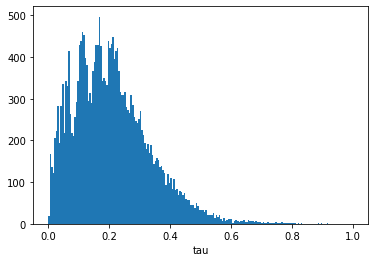

In [10]:
a = plt.hist(tau,bins=200,range=(0,1))
plt.xlabel('tau')

In [11]:
tau_trim = np.clip(tau,0,1) # tau should be between 0 and 1

## Making the depth map <a id="depth" />
Now that we have the needed quantities, we can begin to make our depth map.  Our procedure will be to create a Healpix map, use the coordinates of the HDU corners to identify which healpixels are spanned by each HDU, and add the value of $\tau$ for those HDUs to the appropriate Healpixels.  A couple of notes:

* We approximate the corners of the HDUs using its bounding box.  The bounding box values are faster to retrieve, are guaranteed to be ordered, but are less accurate the the corners.
* We'll need to loop over all of the HDUs one at a time, which can be slow.  Parallel processing might help here.


### Approximate corners using bounding box
This avoids the need to sort the corners.

In [12]:
radectab_s = list(zip(
    dfmc[['hdu:ra_min','hdu:ra_max','hdu:ra_max','hdu:ra_min']].values,
    dfmc[['hdu:dec_max','hdu:dec_max','hdu:dec_min','hdu:dec_min']].values))
vectab = [hp.ang2vec(ra1,dec1,lonlat=True) for ra1, dec1 in radectab_s]

#### Define the Healpix map

In [13]:
nside = 4096
print('Resolution is {:5.2f} arcmin'.format(hp.nside2resol(nside,arcmin=True)))
map = np.zeros(hp.nside2npix(nside)) # raw exposure map
tmap = map.copy() # teff map

Resolution is  0.86 arcmin


#### Loop over HDUs (slow!)

In [14]:
%%time
for vec,exptime,tau1 in zip(vectab,dfmc['exposure'],tau_trim):
    try:
        ipix = hp.query_polygon(nside,vec)
        map[ipix] += exptime
        tmap[ipix] += tau1 * exptime
    except:
        pass

CPU times: user 24.6 s, sys: 62.2 ms, total: 24.6 s
Wall time: 24.6 s


In [15]:
np.count_nonzero(tmap) #@@@

4977012

#### Show the map

/home/pothiers/sandbox/nat-nb/venv/lib/python3.8/site-packages/healpy/projaxes.py:202: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  aximg = self.imshow(


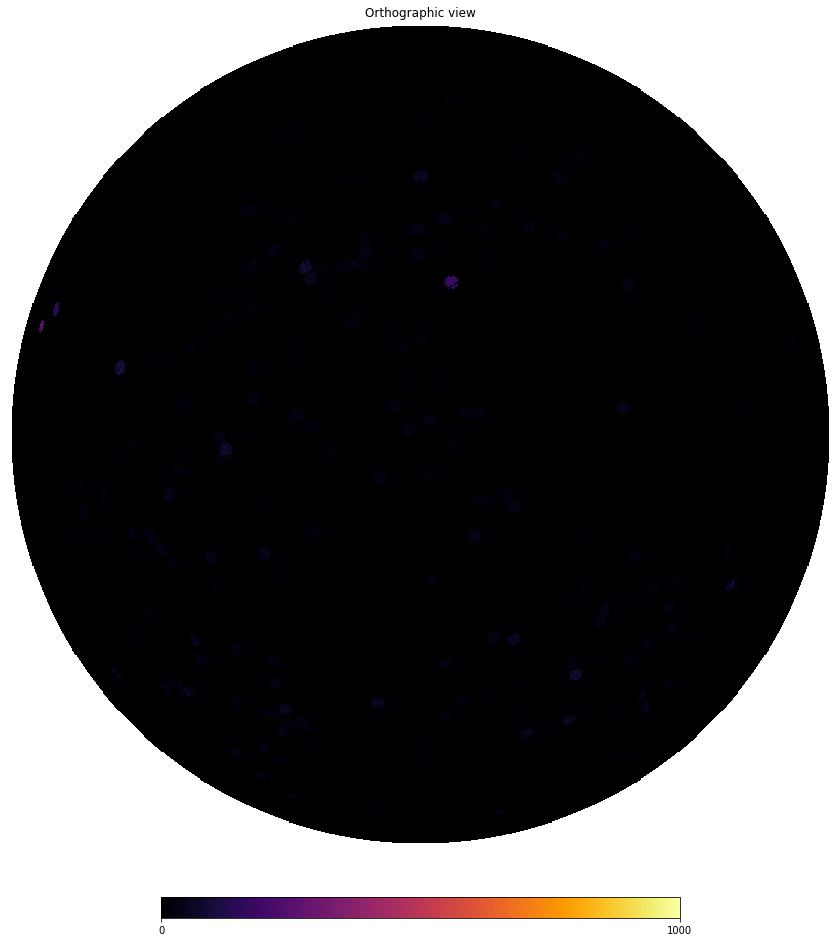

In [16]:
fig = plt.figure(figsize=(15,15))
cmap = copy.copy(matplotlib.cm.get_cmap("inferno"))
hp.orthview(tmap,rot=(20,-30),fig=1,cmap=cmap,half_sky=True,min=0,max=1000)

#### Zooming in

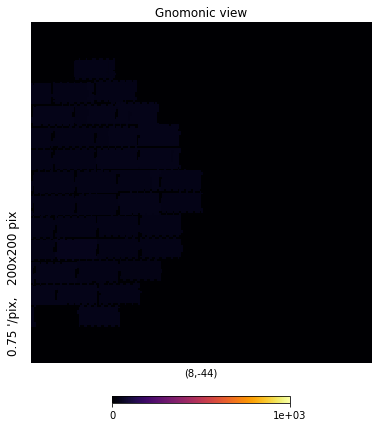

In [17]:
hp.gnomview(tmap,reso=0.75,cmap=cmap,rot=(8,-44),min=0,max=1000)

#### Show the map

In [18]:
import datetime
elapsed = toc()  # Seconds since start of Notebook load (assuming fresh run)
print(f'Elapsed seconds={elapsed} on {natroot}')
print(f'Completed on: {str(datetime.datetime.now())}')
assert natroot == 'https://astroarchive.noao.edu', 'Notebook does NOT point to PRODUCTION'

Elapsed seconds=33.71206110494677 on http://marsnat1.pat.dm.noao.edu:8000
Completed on: 2020-12-23 15:23:24.338858


AssertionError: Notebook does NOT point to PRODUCTION

## Resources and references <a id="docs" />
* Advanced Search [notebook](https://github.com/NOAO/nat-nb)
* Nielsen, E. et al., 2016, [FERMILAB-TM-2610-AE-CD](https://www.osti.gov/biblio/1250877-limiting-magnitude-teff-image-quality-des-year)
* https://algorithmtutor.com/Computational-Geometry/Area-of-a-polygon-given-a-set-of-points/